<a href="https://colab.research.google.com/github/Dalthirr/NeuralNetworks/blob/Model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary modules and data

In [25]:
import numpy as np
import pandas as pd
import sklearn
import keras
import seaborn
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
!pip install -q keras_metrics
import keras_metrics
from sklearn.model_selection import cross_validate
#!pip install livelossplot
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import precision_recall_fscore_support as score
import random


In [8]:
url = 'https://raw.githubusercontent.com/Dalthirr/NeuralNetworks/master/Churn_Modelling.csv'
#Pobieranie danych
df=pd.read_csv(url)
df = df.drop(["CustomerId", "Surname", "RowNumber"],
        axis=1)
df = pd.concat([df, pd.get_dummies(df[["Gender", "Geography"]], drop_first=True)],
               sort=False, axis=1).drop(df[["Gender", "Geography"]], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Gender_Male          10000 non-null uint8
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


## Tworzymy zbiór treningowy i testowy, standaryzujemy i stratyfikujemy odpowiednio do proporcji etykiet

In [9]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)

X_test_std = scaler.transform(X_test)

X_std = scaler.transform(X)


c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


## Modele

### Tomasz Sołtysiak

Zbuduję przykładową sieć, która składa się z warstwy wejściowej, jednej warstwy ukrytej i  warstwy wyjściowej.
Kompilujemy model przy użyciu 

loss_function='binary_crossentropy';

optimizer='Adam'.


Naszą główną metryką będzie **precyzja** oznaczająca procent osób prawidłowie określonych jako zagrożone odejściem.

In [10]:
# Pierwsze podejście do modelu
# Creating Model, I will build simple networt using Sequential.
model=Sequential()
# Add an input layer shape depends on shape of X. We have 11 columns in X.
model.add(Dense(11, activation='relu', input_shape=(11,)))

# Add one hidden layer 
model.add(Dense(121, activation='relu'))



# Add an output layer 
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras_metrics.precision(),'accuracy'])
                   
model.fit(X_train_std, y_train,epochs=3, batch_size=1, verbose=1,validation_data=(X_test,y_test))

model.evaluate(X_test_std,y_test)

Train on 6700 samples, validate on 3300 samples
Epoch 1/3
6700/6700 [==============================] - 27s 4ms/step - loss: 0.4371 - precision: 0.6416 - acc: 0.8176 - val_loss: 7.2359 - val_precision: 0.2406 - val_acc: 0.5467
Epoch 2/3
6700/6700 [==============================] - 27s 4ms/step - loss: 0.3703 - precision: 0.7184 - acc: 0.8484 - val_loss: 8.3476 - val_precision: 0.2429 - val_acc: 0.4770
Epoch 3/3
3300/3300 [==============================] - 0s 51us/step


[0.3510699897823912, 0.7443946186671762, 0.8624242424242424]

In [13]:
#Sprawdźmy skuteczność naszej predykcji - raportem klasyfikacyjnym
y_pred = model.predict_classes(X_test_std)
report = classification_report(y_test,y_pred)
report1 = classification_report(y_test,y_pred,output_dict=True)
print(report)
print(report1['0']['precision'])


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2628
           1       0.74      0.49      0.59       672

   micro avg       0.86      0.86      0.86      3300
   macro avg       0.81      0.73      0.76      3300
weighted avg       0.85      0.86      0.85      3300

0.8808689558514365


In [14]:
# Sprawdźmy, jak prezentują się wyniki w zależności od liczby
# neuronów w warstwie ukrytej.
nodes = [10, 30, 50, 70, 90, 110]
wyniki = {}
for i in nodes:
    model = 0
    # Creating Model, I will build simple networt using Sequential.
    model = Sequential()
    # Add an input layer shape depends on shape of X. We have 11 columns in X.
    model.add(Dense(11, activation='relu', input_shape=(11,)))

    # Add one hidden layer
    model.add(Dense(i, activation='relu'))

    # Add an output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[keras_metrics.precision(), 'accuracy'])

    model.fit(X_train_std, y_train, epochs=5, batch_size=1, verbose=1, validation_data=(X_test, y_test))
    print("Zakończono trenowanie modelu z {0} węzłami.".format(i))
    model.evaluate(X_test_std, y_test)
    y_pred = model.predict_classes(X_test_std)
    report = classification_report(y_test, y_pred, output_dict=True)
    wyniki.update({i: [report['0']['precision'], report['1']['precision']]})

print(wyniki)


Train on 6700 samples, validate on 3300 samples
Epoch 1/5
6700/6700 [==============================] - 26s 4ms/step - loss: 0.4516 - precision: 0.5463 - acc: 0.8025 - val_loss: 5.8813 - val_precision: 0.2472 - val_acc: 0.6321
Epoch 2/5
6700/6700 [==============================] - 26s 4ms/step - loss: 0.3791 - precision: 0.7118 - acc: 0.8430 - val_loss: 4.2664 - val_precision: 0.2790 - val_acc: 0.7339
Epoch 3/5
6700/6700 [==============================] - 26s 4ms/step - loss: 0.3553 - precision: 0.7490 - acc: 0.8540 - val_loss: 5.2095 - val_precision: 0.2420 - val_acc: 0.6748
Epoch 4/5
6700/6700 [==============================] - 32s 5ms/step - loss: 0.3505 - precision: 0.7541 - acc: 0.8564 - val_loss: 6.6508 - val_precision: 0.2440 - val_acc: 0.5839
Epoch 5/5
6700/6700 [==============================] - 28s 4ms/step - loss: 0.3470 - precision: 0.7558 - acc: 0.8585 - val_loss: 7.8858 - val_precision: 0.2452 - val_acc: 0.5061
Zakończono trenowanie modelu z 10 węzłami.
3300/3300 [========

In [15]:
# Wybieramy model z 90 węzłami - dał najlepsze wyniki
from keras.callbacks import EarlyStopping

model = Sequential()
# Add an input layer shape depends on shape of X. We have 11 columns in X.
model.add(Dense(11, activation='relu', input_shape=(11,)))
model.add(Dropout(0.1, ))
# Add one hidden layer 
model.add(Dense(90, activation='relu'))

# Add an output layer 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras_metrics.precision(), 'accuracy'])

early_stopping_monitor = EarlyStopping(patience=2)
model.fit(X_train_std, y_train, epochs=30, batch_size=1, verbose=1, validation_data=(X_test, y_test),
          callbacks=[early_stopping_monitor])

model.evaluate(X_test_std, y_test)
y_pred = model.predict_classes(X_test_std)
report = classification_report(y_test, y_pred)
report1 = classification_report(y_test, y_pred, output_dict=True)
print(report)



Train on 6700 samples, validate on 3300 samples
Epoch 1/30
6700/6700 [==============================] - 29s 4ms/step - loss: 0.4382 - precision: 0.6084 - acc: 0.8094 - val_loss: 8.3561 - val_precision: 0.1639 - val_acc: 0.4770
Epoch 2/30
6700/6700 [==============================] - 27s 4ms/step - loss: 0.3792 - precision: 0.6855 - acc: 0.8364 - val_loss: 12.6708 - val_precision: 0.2039 - val_acc: 0.2052
Epoch 3/30
3300/3300 [==============================] - 0s 52us/step
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2628
           1       0.79      0.40      0.53       672

   micro avg       0.86      0.86      0.86      3300
   macro avg       0.82      0.69      0.72      3300
weighted avg       0.85      0.86      0.84      3300



## Paweł Bogdan

In [16]:
#Wczytuję dane - tym razem wyrzucam również informację odnośnie
#posiadania karty kredytowej - korelacja ze zmienną objaśnianą
#wynosiła 0.0003
df2 = pd.read_csv(url).drop(["CustomerId", "Surname", "RowNumber", "HasCrCard"],
                            axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2[["Gender", "Geography"]], drop_first=True)],
               sort=False, axis=1).drop(df2[["Gender", "Geography"]], axis=1)

X2=df2.drop(['Exited'], axis=1)
y2=df2['Exited']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)


scaler2 = StandardScaler().fit(X_train2)
X_train_std2 = scaler2.transform(X_train2)

X_test_std2 = scaler2.transform(X_test2)

X_std2 = scaler2.transform(X2)

#Poza standaryzacja i stratyfikacją zbioru treningowego i testowego
#ustalam również wagi dla danych klas
class_weight = {
                0: 3.,
                1: 1.
               }

es = EarlyStopping(monitor='val_precision', mode='max', verbose=1, patience=3)




c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


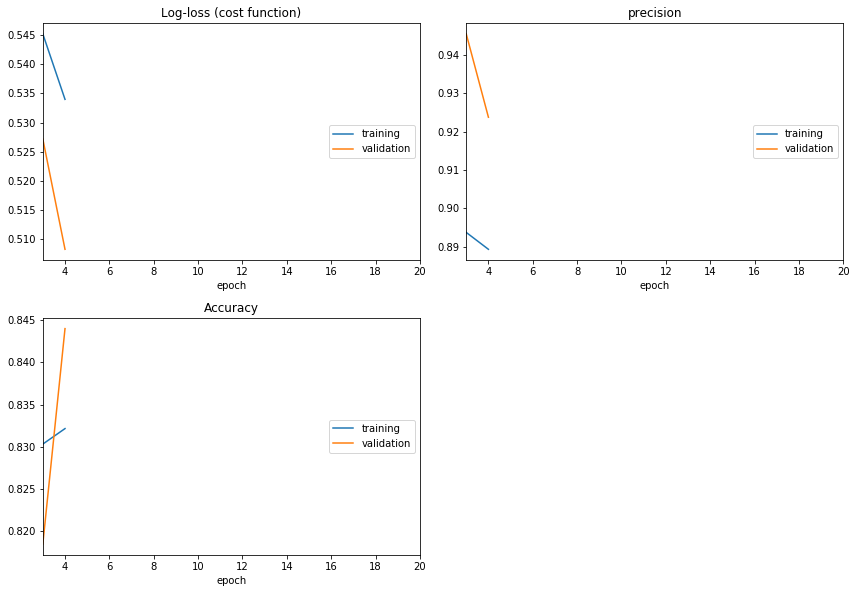

Log-loss (cost function):
training   (min:    0.534, max:    0.650, cur:    0.534)
validation (min:    0.508, max:    0.594, cur:    0.508)

precision:
training   (min:    0.583, max:    0.894, cur:    0.889)
validation (min:    0.924, max:    1.000, cur:    0.924)

Accuracy:
training   (min:    0.797, max:    0.832, cur:    0.832)
validation (min:    0.794, max:    0.844, cur:    0.844)
Epoch 00004: early stopping


In [19]:
#Buduję pierwszy model - w callbacku korzystam z metody
#PlotLossesKeras(), która umożliwi nam tworzenie interesujących nas
#wykresów danych metryk w czasie rzeczywistym
#korzystam również z early stopping zdefiniowanego wyżej, aby nie dopuścić
#do przetrenowania modelu
model2 = Sequential()
model2.add(Dense(20, activation='relu', input_shape=(10,)))


model2.add(Dropout(0.1,))
model2.add(Dense(75, activation='relu'))


model2.add(Dense(1, activation='sigmoid'))


model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras_metrics.precision(),'accuracy'])
                   
model2.fit(X_train_std2, y_train2, epochs=20, batch_size=2,
           verbose=1, validation_split=0.25, callbacks = [PlotLossesKeras(), es], class_weight=class_weight)

In [20]:
#Sprawdźmy predykcję i wygenerujmy raport klasyfikacyjny
y_pred2 = model2.predict_classes(X_test_std2)

report = classification_report(y_test2, y_pred2, output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1593
           1       0.91      0.24      0.38       407

   micro avg       0.84      0.84      0.84      2000
   macro avg       0.87      0.62      0.64      2000
weighted avg       0.85      0.84      0.80      2000



## Patrycja Studzienna i Karolina Schmidt

In [37]:
url = 'https://raw.githubusercontent.com/Dalthirr/NeuralNetworks/master/Churn_Modelling.csv'
#Pobieranie danych
df = pd.read_csv(url)
df = df.drop(["CustomerId", "Surname", "RowNumber"],
             axis=1)
df = pd.concat([df, pd.get_dummies(df[["Gender", "Geography"]], drop_first=True)],
               sort=False, axis=1).drop(df[["Gender", "Geography"]], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Gender_Male          10000 non-null uint8
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [38]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)

X_test_std = scaler.transform(X_test)

X_std = scaler.transform(X)

c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


**Equalising the subsets**

In [39]:
df = df.drop(["HasCrCard"],
            axis=1)
#empty list for index
random_list = []
for i in range(len(df.values)):
  #sampling from uniform distribution 
  if (df['Exited'].values)[i] == 0 and random.random() > 0.35:
    random_list.append(i)
    
#equalising the subsets
eq_df = df.drop(random_list)
#dropped data
val_df = df.ix[random_list]
# split into input X and output y variables
X = (eq_df.drop(['Exited'], axis=1)) #dropping exited
y = eq_df.Exited
#splitting data for train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)
#standardization
scaler = StandardScaler().fit(X_train)
X_train_centered = scaler.transform(X_train)
X_test_centered = scaler.transform(X_test)

c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to fl

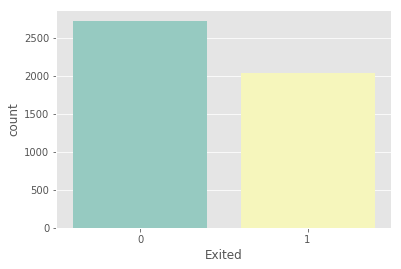

In [40]:
ax = seaborn.countplot(x='Exited', data=eq_df, palette='Set3')
df.loc[:,'Exited'].value_counts()
plt.show()

In [41]:
model=Sequential()
# Add an input layer shape depends on shape of X. We have 11 columns in X.
model.add(Dense(11, activation='relu', kernel_initializer=keras.initializers.glorot_normal(seed=None), input_shape=(10,)))
#glorot initializer  normal, uniform
#X.Glorot, Y.Benjo, Understanding the difficulty of deep feedforward neural networks
# Add one hidden layer 
model.add(Dense(36, activation='tanh', kernel_initializer=keras.initializers.glorot_normal(seed=None)))


# Add an output layer 
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[keras_metrics.precision(), 'accuracy'])
                 
 
history = model.fit(X_train_centered, y_train, validation_split=0.15, epochs=25, batch_size=3, verbose=1)

Train on 3439 samples, validate on 608 samples
Epoch 1/25
3439/3439 [==============================] - 4s 1ms/step - loss: 0.5902 - precision: 0.6598 - acc: 0.6848 - val_loss: 0.5571 - val_precision: 0.7128 - val_acc: 0.7138
Epoch 2/25
3439/3439 [==============================] - 4s 1ms/step - loss: 0.5482 - precision: 0.7002 - acc: 0.7235 - val_loss: 0.5353 - val_precision: 0.7168 - val_acc: 0.7385
Epoch 3/25
3439/3439 [==============================] - 4s 1ms/step - loss: 0.5233 - precision: 0.7173 - acc: 0.7435 - val_loss: 0.5174 - val_precision: 0.7711 - val_acc: 0.7566
Epoch 4/25
3439/3439 [==============================] - 4s 1ms/step - loss: 0.4990 - precision: 0.7404 - acc: 0.7627 - val_loss: 0.4850 - val_precision: 0.7448 - val_acc: 0.7697
Epoch 5/25
3439/3439 [==============================] - 4s 1ms/step - loss: 0.4802 - precision: 0.7425 - acc: 0.7703 - val_loss: 0.4837 - val_precision: 0.7533 - val_acc: 0.7664
Epoch 6/25
3439/3439 [==============================] - 4s 1ms/

In [43]:
!pip install -q graphviz
!pip install -q ann_visualizer
from ann_visualizer.visualize import ann_viz
ann_viz(model, view=True, filename="model")

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'model'], make sure the Graphviz executables are on your systems' PATH

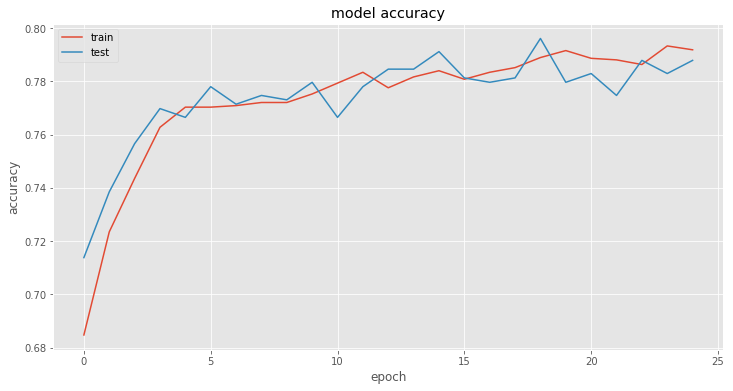

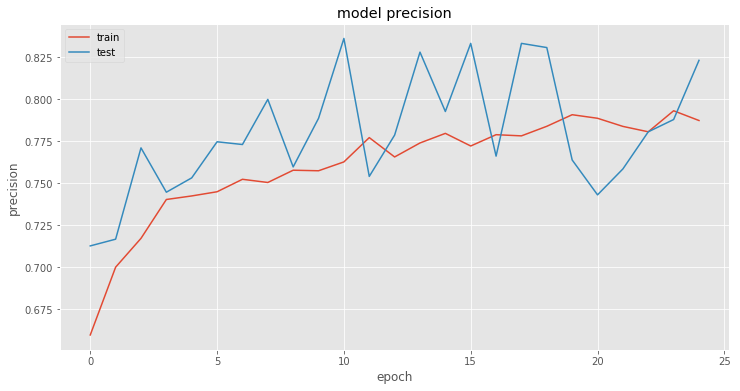

In [44]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize = (12,6))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

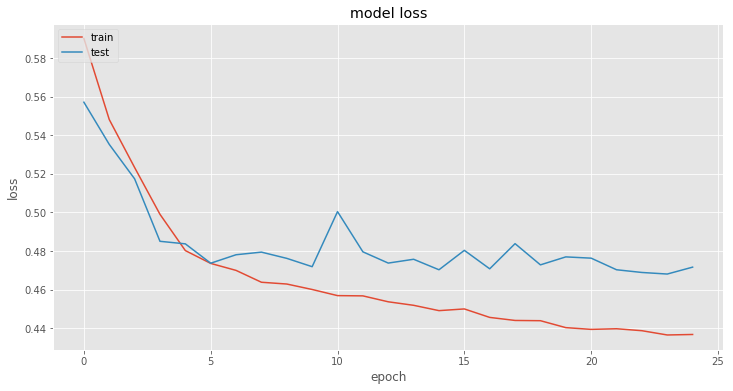

In [45]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Performance Metrics**

**Confusion matrix**

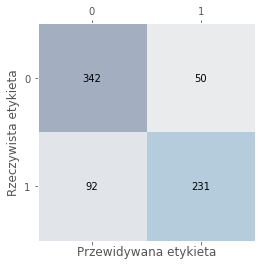

In [46]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test_centered)
confmat = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=.3)
plt.grid()
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    
plt.xlabel('Przewidywana etykieta')
plt.ylabel('Rzeczywista etykieta')
plt.show()

In [47]:
FP = confmat[1][0]   #false positive
TP = confmat[1][1]   #true positive
TN = confmat[0][0]   #true negative
FN = confmat[0][1]   #false negative

error = (FP+FN)/(FP+FN+TP+TN)*100
acc = (TP+TN)/(FP+FN+TP+TN)*100

ofp = FP/(FP+TN)*100   #true positive rate
opp = TP/(FN+TP)*100   #false positive rate

pre = TP/(TP+FP)*100   #precision
recall = TP/(FN+TP)*100 #recall (pełność)

print("Błąd %f%% " % error)
print("Dokładność %f%% " % acc)
print("Precision %f%% " % pre)
print("Recall %f%% " % recall)
print("True positive rate %f%% " % ofp)
print("False positive rate %f%% " % opp)

Błąd 19.860140% 
Dokładność 80.139860% 
Precision 71.517028% 
Recall 82.206406% 
True positive rate 21.198157% 
False positive rate 82.206406% 


**Rejected samples**

In [48]:
val_df = df.ix[random_list]
# split into input X and output y variables
X_val = (val_df.drop(['Exited'], axis = 1)) #dropping exited
y_val = val_df.Exited
#standardization
scaler=StandardScaler().fit(X_val)
X_val_centered = scaler.transform(X_val)
y_vpred = model.predict_classes(X_val_centered)
val_confmat = confusion_matrix(y_val,y_vpred)
val_FP = val_confmat[1][0]   #false positive
val_TP = val_confmat[1][1]   #true positive
val_TN = val_confmat[0][0]   #true negative
val_FN = val_confmat[0][1]   #false negative
val_error = (val_FP+val_FN)/(val_FP+val_FN+val_TP+val_TN)*100
val_acc = (val_TP+val_TN)/(val_FP+val_FN+val_TP+val_TN)*100
print("Ilość próbek %f, Poprawnie sklasyfikowane %f" %(int(len(y_val)), int(val_confmat[0][0])))
print("Błąd %f%% " % val_error)
print("Dokładność %f%% " % val_acc)

Ilość próbek 5238.000000, Poprawnie sklasyfikowane 3545.000000
Błąd 32.321497% 
Dokładność 67.678503% 


c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\sebas\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys
